### Import of libraries
We will import the libraries for deep learning methods.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix


from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.8.2


### Import of Data
We will import the data from the following link given below

In [ ]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Alz_data.zip"
!unzip -qo Alz_data.zip 
!rm Alz_data.zip

--2022-07-05 09:12:47--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Alz_data.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.156.139
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.156.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35524854 (34M) [application/x-zip-compressed]
Saving to: ‘Alz_data.zip’

Alz_data.zip        100%[===================>]  33.88M  17.9MB/s    in 1.9s    

2022-07-05 09:12:49 (17.9 MB/s) - ‘Alz_data.zip’ saved [35524854/35524854]



### Data preprocessing

We will perform data augmentation

In [ ]:
base_dir = "/content/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['NonDemented', 'ModerateDemented', 'VeryMildDemented', 'MildDemented']


### Data Augmentation

In [ ]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
#data augmentation params

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


### Data Visualization

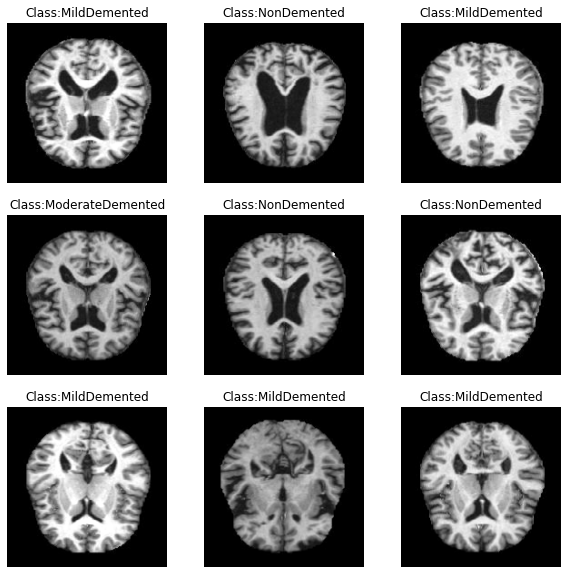

In [ ]:
def show_images(generator,y_pred=None):
    """
    function to display images
    """
    
    # get labels
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # generate batches
    x,y = generator.next()
    
    # display random images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Image visualization
show_images(train_data_gen)

In [ ]:
#Retrieve data from augmentation

train_data, train_labels = train_data_gen.next()

In [ ]:
#Data dimension

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


### Data Balancing
We will balance the data using SMOTE technique which will create synthetic points to increase the size of the sample.

In [ ]:
#perform SMOTE
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


### Data Splitting
We will split the data for training and testing where 80% of the data for training and rest for testing and validation

In [ ]:
#Split data 
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### Model Building
We will build the model using Inception V3 where we will define functions to build different layers

In [ ]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in inception_model.layers:
    layer.trainable=False

Custom model will be build using different layers and activation function.

In [ ]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

### Model plot

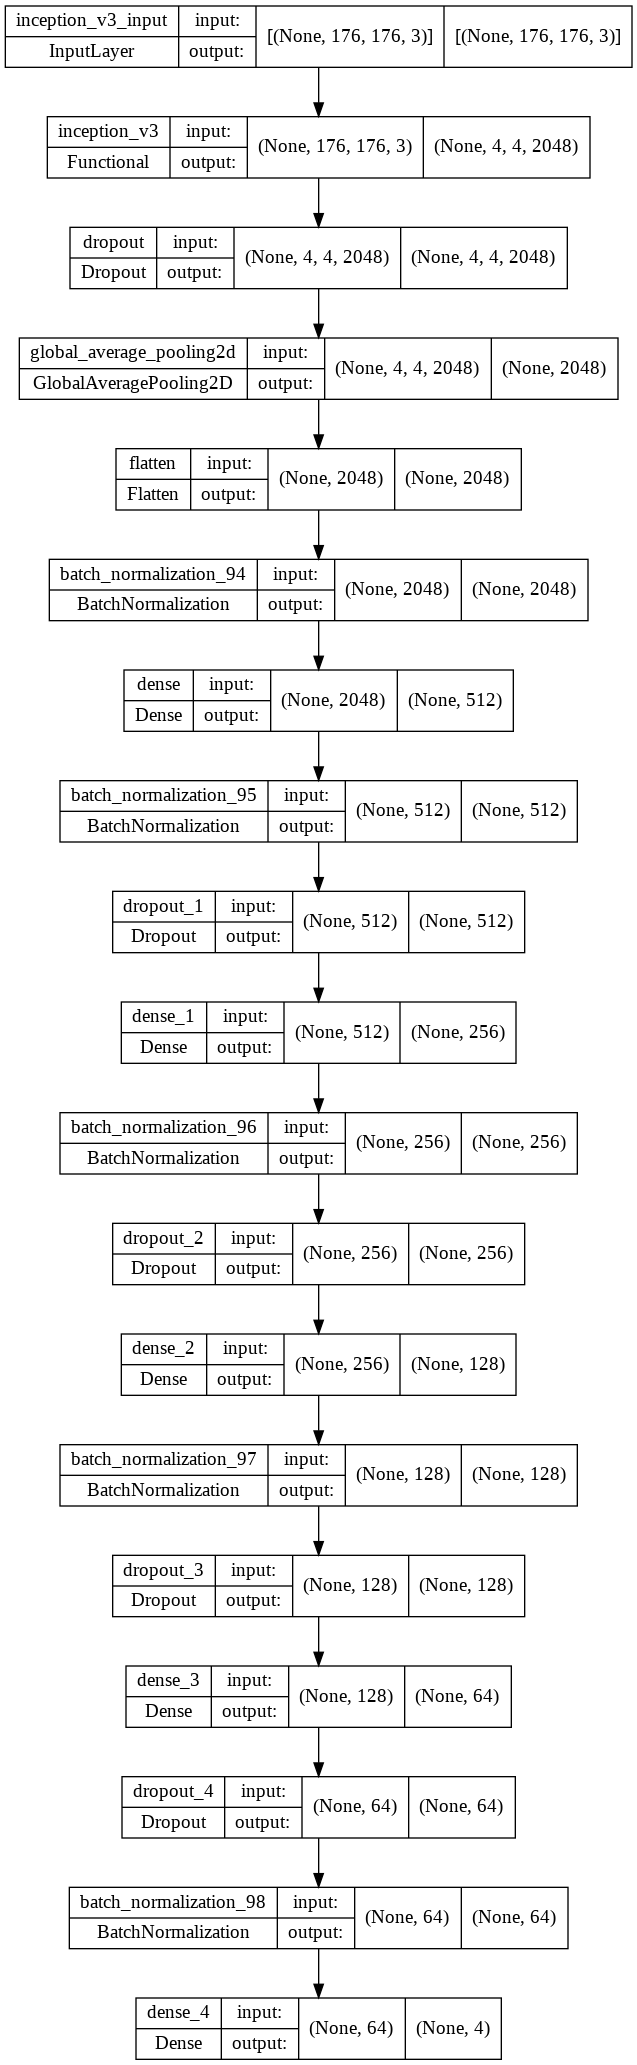

In [ ]:
#plot model architecture
plot_model(custom_inception_model)

### Model compilation
We will compile the model using Adam optimizer and loss function

In [ ]:
#model compile with summary  
custom_inception_model.compile(optimizer='Adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=['accuracy'])

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)       

### Model Building
We will build the model using 50 epochs on train data and validate on validated data.

In [ ]:
#fit the model using inception architecture
EPOCHS = 50

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels),  epochs=EPOCHS)

Epoch 1/50
256/256 [==============================] - 28s 52ms/step - loss: 1.4409 - accuracy: 0.3846 - val_loss: 0.8373 - val_accuracy: 0.6172
Epoch 2/50
256/256 [==============================] - 12s 46ms/step - loss: 0.9745 - accuracy: 0.5472 - val_loss: 0.7119 - val_accuracy: 0.6719
Epoch 3/50
256/256 [==============================] - 12s 46ms/step - loss: 0.8495 - accuracy: 0.5996 - val_loss: 0.6598 - val_accuracy: 0.6865
Epoch 4/50
256/256 [==============================] - 12s 46ms/step - loss: 0.7830 - accuracy: 0.6326 - val_loss: 0.6341 - val_accuracy: 0.7144
Epoch 5/50
256/256 [==============================] - 12s 46ms/step - loss: 0.7338 - accuracy: 0.6700 - val_loss: 0.6048 - val_accuracy: 0.7080
Epoch 6/50
256/256 [==============================] - 12s 46ms/step - loss: 0.7158 - accuracy: 0.6715 - val_loss: 0.5754 - val_accuracy: 0.7490
Epoch 7/50
256/256 [==============================] - 12s 46ms/step - loss: 0.6810 - accuracy: 0.6915 - val_loss: 0.5629 - val_accuracy:

### Model plots
We will visualize the model to understand model accuracy and losses

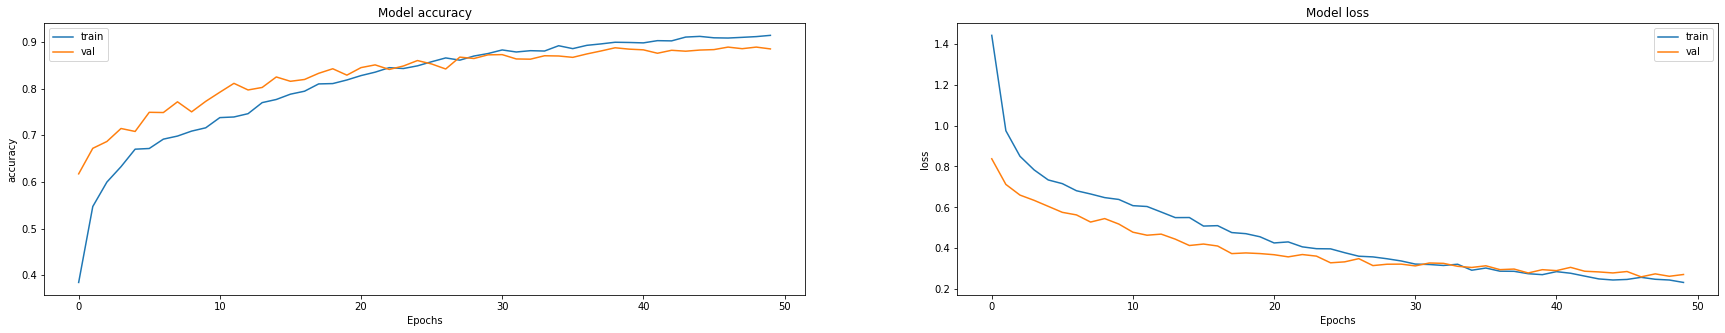

In [ ]:
#model accuracy and model loss
fig, ax = plt.subplots(1, 2, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

### Model Evalaution
We will evalaute the model on the test data.

In [ ]:
#evaluation on test data
test_scores = custom_inception_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 3s 36ms/step - loss: 0.3079 - accuracy: 0.8898
Testing Accuracy: 88.98%


In [ ]:
#Prediction of labels
pred_labels = custom_inception_model.predict(test_data)

In [ ]:
#confusion matrix and classification report
def roundoff(arr):
    """ffunction of confusion matrix """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.93      0.95      0.94       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.88      0.75      0.81       662
ModerateDemented       0.76      0.87      0.81       624

       micro avg       0.89      0.89      0.89      2560
       macro avg       0.89      0.89      0.89      2560
    weighted avg       0.89      0.89      0.89      2560
     samples avg       0.89      0.89      0.89      2560



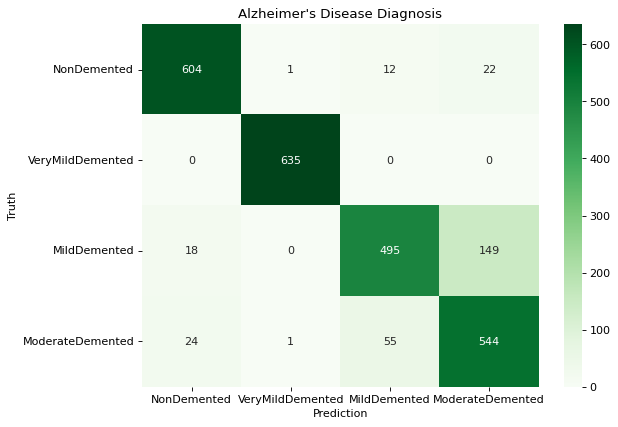

In [ ]:
#plot confusion matrix and classification report

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
#balanced accuracy score and mathews correlation coefficient
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 89.12 %
Matthew's Correlation Coefficient: 85.48 %
